In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import \
    get_config

In [2]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)
local_bw_rmses = {}
global_bw_rmses = {}

2


0.01085543881080128 0.0005783557700035098 inf


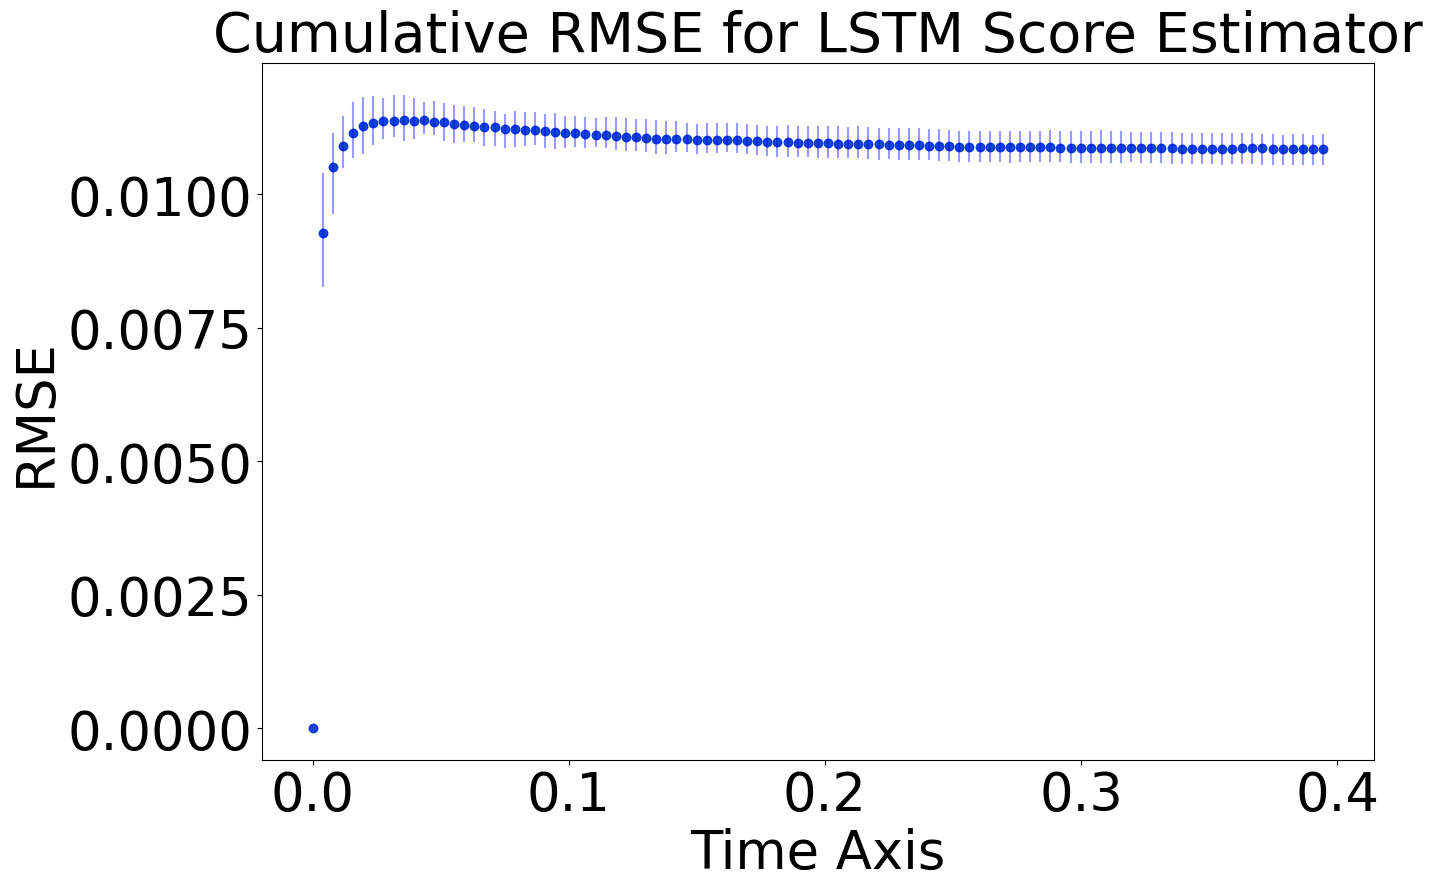

Final time cumulative RMSE local-time error 0.01085543881080128 with final IQR (0.010540826524781093, 0.011119182294784603) at Nepoch 60

0.016395754526582502 0.0007286586240483166 0.01085543881080128
0.006664038658665954 0.0006393468006110287 0.01085543881080128


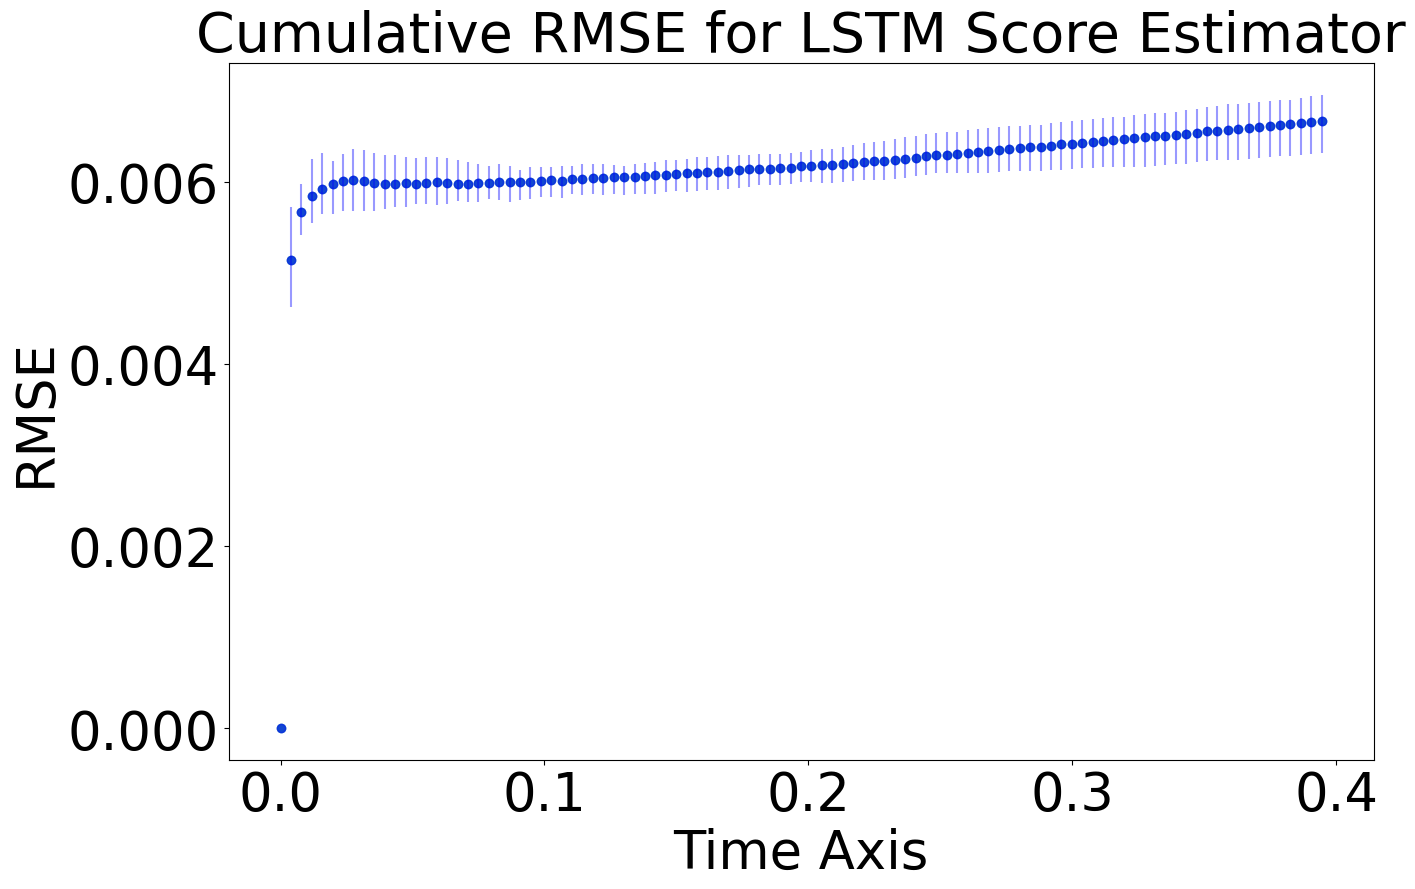

Final time cumulative RMSE local-time error 0.006664038658665954 with final IQR (0.006313894816174497, 0.006953241616785526) at Nepoch 150

0.010153278538530989 0.0002675250522848633 0.006664038658665954
0.007349168880841106 0.0006302143911025302 0.006664038658665954
0.015017525885972766 0.001002884873797346 0.006664038658665954
0.01503257488934771 0.0010443033756055466 0.006664038658665954
0.00924343792466194 0.00035204088800068305 0.006664038658665954
0.014297456732691722 0.0006785175368806302 0.006664038658665954
0.014703587760309684 0.0011956198223276853 0.006664038658665954
0.009399645530363631 0.000665119568850972 0.006664038658665954
0.011445057106205811 0.00041102183928443115 0.006664038658665954
0.01925729857178813 0.00041403902545889687 0.006664038658665954


In [3]:
curr_rmse = np.inf
toSave = False
for Nepoch in config.max_epochs:
    try:
        if "_ST_" in config.scoreNet_trained_path:
            save_path = (
                    project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_ST_fQuadSinHF_DriftTrack_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                ".", "")
        else:
            save_path = (
                    project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_fQuadSinHF_DriftTrack_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                ".", "")

        all_true_states = np.load(save_path + "_global_true_states.npy")/np.sqrt(config.deltaT)
        all_local_states= np.load(save_path + "_local_states.npy")/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_rmse)
        if total_local_errors[-1]  < curr_rmse:
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1] #- total_local_errors_minq[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(time_steps, total_local_errors)
            #plt.fill_between(time_steps, total_local_errors_minq, total_local_errors_maxq, color="blue", alpha=0.2, label="95% Confidence Band")
            plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)

            ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fQuadSinHF_DriftTrack_{Nepoch}Nep_PM_LSTM_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c").replace(".", "")+".png")
            plt.show()
            plt.close()
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {(total_local_errors[-1])} with final IQR {total_local_errors_minq[-1], total_local_errors_maxq[-1]} at Nepoch {Nepoch}\n")
    except FileNotFoundError as e:
        print(e)
        continue